# BERT (Updated 1 Feb 2025, Available CUDA)

We shall implement BERT.  For this tutorial, you may want to first look at my Transformers tutorial to get a basic understanding of Transformers.

For BERT, the main difference is on how we process the datasets, i.e., masking.   Aside from that, the backbone model is still the Transformers.

In [1]:
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

In [2]:
# Set GPU device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch.cuda.get_device_name(0)

'Tesla T4'

## 1. Data

I will be using 20 famous classic Romance books from https://www.gutenberg.org/

- Pride and Prejudice by Jane Austen
- Jane Eyre: An Autobiography by Charlotte Brontë
- Wuthering Heights by Emily Brontë
- The Blue Castle: a novel by L. M. Montgomery
- The Enchanted April by Elizabeth Von Arnim
- Sense and Sensibility by Jane Austen
- North and South by Elizabeth Cleghorn Gaskell
- Persuasion by Jane Austen
- The Scarlet Pimpernel by Baroness Emmuska Orczy Orczy
- A Room with a View by E. M. Forster
- The Age of Innocence by Edith Wharton
- Love and Freindship [sic] by Jane Austen
- The Princess and the Goblin by George MacDonald
- The Story of an African Farm by Olive Schreiner
- Lady Susan by Jane Austen
- Emma by Jane Austen
- Our Mutual Friend by Charles Dickens
- This Side of Paradise by F. Scott Fitzgerald
- Anna Karenina by graf Leo Tolstoy
- Middlemarch by George Eliot

### 1.1 Downloading

In [3]:
import requests

def download_gutenberg_book(book_id, output_file):
    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    response = requests.get(url)
    if response.status_code == 200:
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"Downloaded book {book_id} to {output_file}")
    else:
        print(f"Failed to download book {book_id}")

In [4]:
download_gutenberg_book(1342, "pride_and_prejudice.txt")

Downloaded book 1342 to pride_and_prejudice.txt


In [5]:
download_gutenberg_book(1260, "jane_eyre.txt")

Downloaded book 1260 to jane_eyre.txt


In [6]:
download_gutenberg_book(768, "wuthering_heights.txt")

Downloaded book 768 to wuthering_heights.txt


In [7]:
download_gutenberg_book(67979, "the_blue_castle.txt")

Downloaded book 67979 to the_blue_castle.txt


In [8]:
download_gutenberg_book(16389, "the_enchanted_april.txt")

Downloaded book 16389 to the_enchanted_april.txt


In [9]:
download_gutenberg_book(161, "sense_and_sensibility.txt")

Downloaded book 161 to sense_and_sensibility.txt


In [10]:
download_gutenberg_book(4276, "north_and_south.txt")

Downloaded book 4276 to north_and_south.txt


In [11]:
download_gutenberg_book(105, "persuasion.txt")

Downloaded book 105 to persuasion.txt


In [12]:
download_gutenberg_book(60, "the_scarlet_pimpernel.txt")

Downloaded book 60 to the_scarlet_pimpernel.txt


In [13]:
download_gutenberg_book(2641, "a_room_with_a_view.txt")

Downloaded book 2641 to a_room_with_a_view.txt


In [14]:
download_gutenberg_book(541, "the_age_of_innocence.txt")

Downloaded book 541 to the_age_of_innocence.txt


In [15]:
download_gutenberg_book(1212, "love_and_freindship.txt")

Downloaded book 1212 to love_and_freindship.txt


In [16]:
download_gutenberg_book(708, "the_princess_and_the_goblin.txt")

Downloaded book 708 to the_princess_and_the_goblin.txt


In [17]:
download_gutenberg_book(1441, "the_story_of_an_african_farm.txt")

Downloaded book 1441 to the_story_of_an_african_farm.txt


In [18]:
download_gutenberg_book(946, "lady_susan.txt")

Downloaded book 946 to lady_susan.txt


In [19]:
download_gutenberg_book(158, "emma.txt")

Downloaded book 158 to emma.txt


In [20]:
download_gutenberg_book(883, "our_mutual_friend.txt")

Downloaded book 883 to our_mutual_friend.txt


In [21]:
download_gutenberg_book(805, "this_side_of_paradise.txt")

Downloaded book 805 to this_side_of_paradise.txt


In [22]:
download_gutenberg_book(1399, "anna_karenina.txt")

Downloaded book 1399 to anna_karenina.txt


In [23]:
download_gutenberg_book(145, "middlemarch.txt")

Downloaded book 145 to middlemarch.txt


### 1.2 Clean and Tokenize

In [24]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
def clean_text(file_path_list):
    cleaned_text = []
    for file_path in file_path_list:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        # Remove Gutenberg header and footer
        start_index = next(i for i, line in enumerate(lines) if "*** START OF THE PROJECT GUTENBERG EBOOK" in line) + 1
        end_index = next(i for i, line in enumerate(lines) if "*** END OF THE PROJECT GUTENBERG EBOOK" in line) - 1

        raw_text = " ".join(lines[start_index:end_index])
        sentences = sent_tokenize(re.sub(r'\s+', ' ', raw_text.replace("\n", " ").strip()))
        tokens = [word_tokenize(sentence.lower()) for sentence in sentences]
        cleaned_text.extend(tokens)
    return cleaned_text

In [26]:
text = clean_text(['pride_and_prejudice.txt', 'jane_eyre.txt', 'wuthering_heights.txt', 'the_blue_castle.txt', 'the_enchanted_april.txt',
                        'sense_and_sensibility.txt', 'north_and_south.txt', 'persuasion.txt', 'the_scarlet_pimpernel.txt', 'a_room_with_a_view.txt',
                        'the_age_of_innocence.txt', 'love_and_freindship.txt', 'the_princess_and_the_goblin.txt', 'the_story_of_an_african_farm.txt',
                        'lady_susan.txt', 'emma.txt', 'our_mutual_friend.txt', 'this_side_of_paradise.txt', 'anna_karenina.txt', 'middlemarch.txt'])
text[-2:]

[['but',
  'the',
  'effect',
  'of',
  'her',
  'being',
  'on',
  'those',
  'around',
  'her',
  'was',
  'incalculably',
  'diffusive',
  ':',
  'for',
  'the',
  'growing',
  'good',
  'of',
  'the',
  'world',
  'is',
  'partly',
  'dependent',
  'on',
  'unhistoric',
  'acts',
  ';',
  'and',
  'that',
  'things',
  'are',
  'not',
  'so',
  'ill',
  'with',
  'you',
  'and',
  'me',
  'as',
  'they',
  'might',
  'have',
  'been',
  ',',
  'is',
  'half',
  'owing',
  'to',
  'the',
  'number',
  'who',
  'lived',
  'faithfully',
  'a',
  'hidden',
  'life',
  ',',
  'and',
  'rest',
  'in',
  'unvisited',
  'tombs',
  '.'],
 ['the', 'end']]

In [27]:
len(text)

121444

### 1.3 Making vocabs

Before making the vocabs, let's remove all question marks and perios, etc, then turn everything to lowercase, and then simply split the text.

In [28]:
from tqdm.auto import tqdm
from collections import Counter

# Combine everything into one to make vocab
word_list = [token for sentence in text for token in sentence]
word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, '[UNK]': 4}  # special tokens


word_counts = Counter(word_list)

# Create the word2id in a single pass
vocab = {word: idx for idx, word in enumerate(word_counts.keys())}
for idx, word in tqdm(enumerate(word_counts.keys()), desc="Creating word2id"):
    word2id[word] = idx + 5

# for i, w in tqdm(enumerate(word_list), desc="Creating word2id"):
#     word2id[w] = word2id.get(w, i + 5)

# Precompute the id2word mapping (this can be done once after word2id is fully populated)
id2word = {v: k for k, v in word2id.items()}
vocab_size = len(word2id)
vocab_size

Creating word2id: 0it [00:00, ?it/s]

60447

In [29]:
vocab_size = len(word2id)

# List of all tokens for the whole text
token_list = []

# Process sentences more efficiently
for sentence in tqdm(text, desc="Processing sentences"):
    token_list.append([word2id[word] for word in sentence])

# Now token_list contains the tokenized sentences

Processing sentences:   0%|          | 0/121444 [00:00<?, ?it/s]

In [30]:
#take a look at sentences
' '.join(text[54453])

'she asked , suddenly turning her face from the window .'

In [31]:
#take a look at token_list
token_list[54453]

[445, 2136, 32, 1829, 2099, 286, 2529, 268, 93, 1988, 27]

## 2. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”.

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred`

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`.

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

In [32]:
batch_size = 32
max_mask   = 5  # max masked tokens when 15% exceed, it will only be max_pred
max_len    = 512 # maximum of length to be padded;

In [33]:
def make_batch():
    batch = []
    positive = negative = 0  #count of batch size;  we want to have half batch that are positive pairs (i.e., next sentence pairs)
    while positive != batch_size/2 or negative != batch_size/2:

        #randomly choose two sentence so we can put [SEP]
        tokens_a_index, tokens_b_index = randrange(len(text)), randrange(len(text))
        #retrieve the two sentences
        tokens_a, tokens_b = token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - append CLS and SEP
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        #2. segment embedding - [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3. mask language modeling
        #masked 15%, but should be at least 1 but does not exceed max_mask
        n_pred =  min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get the pos that excludes CLS and SEP and shuffle them
        cand_maked_pos = [i for i, token in enumerate(input_ids) if token != word2id['[CLS]'] and token != word2id['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and change the input_ids to [MASK]
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)  #remember the position
            masked_tokens.append(input_ids[pos]) #remember the tokens
            #80% replace with a [MASK], but 10% will replace with a random token
            if random() < 0.1:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word2id[id2word[index]] # replace
            elif random() < 0.9:  # 80%
                input_ids[pos] = word2id['[MASK]'] # make mask
            else:  #10% do nothing
                pass

        # pad the input_ids and segment ids until the max len
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # pad the masked_tokens and masked_pos to make sure the lenth is max_mask
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #check if first sentence is really comes before the second sentence
        #also make sure positive is exactly half the batch size
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1

    return batch

In [34]:
batch = make_batch()

In [35]:
#len of batch
len(batch)

32

In [36]:
#we can deconstruct using map and zip
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext.shape

(torch.Size([32, 512]),
 torch.Size([32, 512]),
 torch.Size([32, 5]),
 torch.Size([32, 5]),
 torch.Size([32]))

## 3. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 3.1 Embedding

Here we simply generate the positional embedding, and sum the token embedding, positional embedding, and segment embedding together.

<img src = "figures/BERT_embed.png" width=500>

In [37]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 3.2 Attention mask

In [38]:
def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [39]:
print(get_attn_pad_mask(input_ids, input_ids, device).shape)

torch.Size([32, 512, 512])


## 3.3 Encoder

The encoder has two main components:

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

In [40]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

In [41]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

Let's define the parameters first

In [42]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

Here is the Multiheadattention.

In [43]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]

Here is the PoswiseFeedForwardNet.

In [44]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

## 3.4 Putting them together

In [45]:
class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]

        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp

    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        return output

## 4. Training

In [46]:
from tqdm.auto import tqdm

num_epoch = 1000
model = BERT(
    n_layers,
    n_heads,
    d_model,
    d_ff,
    d_k,
    n_segments,
    vocab_size,
    max_len,
    device
).to(device)  # Move model to GPU

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

# Move inputs to GPU
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

losses = []
# Wrap the epoch loop with tqdm
for epoch in tqdm(range(num_epoch), desc="Training Epochs"):
    optimizer.zero_grad()
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
    #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
    #logits_nsp: (bs, yes/no) ==> (6, 2)

    #1. mlm loss
    #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    #2. nsp loss
    #logits_nsp: (bs, 2) vs. isNext: (bs, )
    loss_nsp = criterion(logits_nsp, isNext) # for sentence classification

    #3. combine loss
    loss = loss_lm + loss_nsp
    losses.append(loss.item())  # Save loss value
    if epoch % 100 == 0:
        print('Epoch:', '%02d' % (epoch), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 00 loss = 121.095024
Epoch: 100 loss = 9.171910
Epoch: 200 loss = 5.074607
Epoch: 300 loss = 5.047955
Epoch: 400 loss = 5.027654
Epoch: 500 loss = 5.009056
Epoch: 600 loss = 5.119434
Epoch: 700 loss = 5.061424
Epoch: 800 loss = 5.146551
Epoch: 900 loss = 5.563886


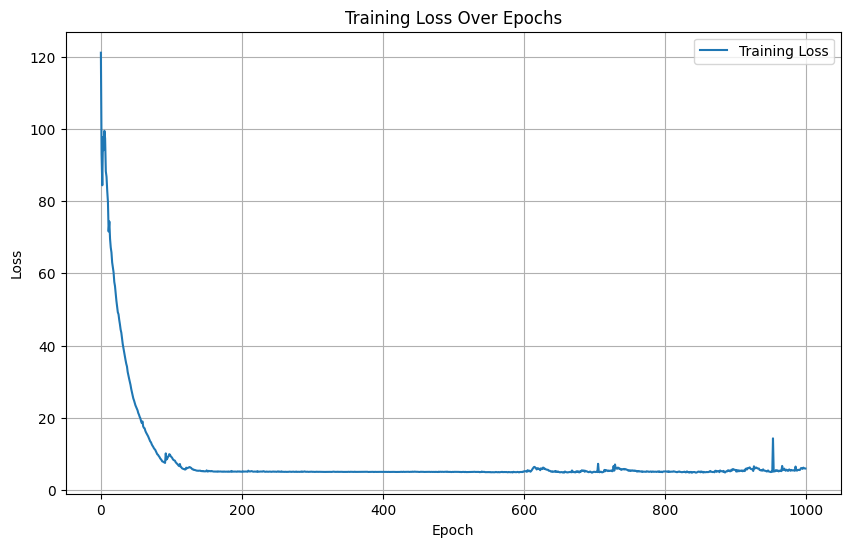

In [49]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [50]:
# Save the model after training
torch.save(model.state_dict(), 'bert_model.pth')
print("Model saved to bert_model.pth")

Model saved to bert_model.pth


## 5. Inference



In [55]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[5]))
print([id2word[w.item()] for w in input_ids[0] if id2word[w.item()] != '[PAD]'])
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy()
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[id2word[pos.item()] for pos in masked_tokens[0]])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0]])
print('masked tokens (words) : ',[id2word[pos.item()] for pos in logits_lm])
print('predict masked tokens list : ', [pos for pos in logits_lm])

#predict nsp
logits_nsp = logits_nsp.cpu().data.max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_nsp else False)

['[CLS]', 'he', 'went', 'up', 'to', 'her', ',', 'bowed', ',', '[MASK]', 'held', 'out', '[MASK]', 'hand', 'without', 'speaking', '.', '[SEP]', 'levin', '[MASK]', '[MASK]', 'story', ',', 'and', 'that', 'too', 'was', 'successful', '.', '[SEP]']
masked tokens (words) :  ['his', 'told', 'his', 'and', '[PAD]']
masked tokens list :  [62, 538, 62, 28, 0]
masked tokens (words) :  ['.', '.', '.', '.', '.']
predict masked tokens list :  [27, 27, 27, 27, 27]
0
isNext :  False
predict isNext :  False


## Saving Model Configs

In [56]:
config = {}

config['n_layers'] = n_layers
config['n_heads'] = n_heads
config['d_model'] = d_model
config['d_ff'] = d_ff
config['d_k'] = d_k
config['d_v'] = d_v
config['n_segments'] = n_segments
config['max_len'] = max_len
config['max_mask'] = max_mask
config['vocab_size'] = vocab_size
config['id2word'] = id2word
config['word2id'] = word2id
config['batch_size'] = batch_size

In [57]:
import pickle

with open('config.pkl', 'wb') as file:
    pickle.dump(config, file)

### Testing

In [58]:
with open('config.pkl', 'rb') as file:
    config = pickle.load(file)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

saved_model = BERT(
    config['n_layers'],
    config['n_heads'],
    config['d_model'],
    config['d_ff'],
    config['d_k'],
    config['n_segments'],
    config['vocab_size'],
    config['max_len'],
    device
).to(device)

saved_model.load_state_dict(torch.load('bert_model.pth'))
model

<ipython-input-60-57208da627a8>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model.load_state_dict(torch.load('bert_model.pth'))


BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(60447, 768)
    (pos_embed): Embedding(512, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decod

In [64]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[3]))
print([id2word[w.item()] for w in input_ids[0] if id2word[w.item()] != '[PAD]'])
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
masked_tokens = masked_tokens.to(device)
masked_pos = masked_pos.to(device)
isNext = isNext.to(device)

logits_lm, logits_nsp = saved_model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy()
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[id2word[pos.item()] for pos in masked_tokens[0]])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0]])
print('masked tokens (words) : ',[id2word[pos.item()] for pos in logits_lm])
print('predict masked tokens list : ', [pos for pos in logits_lm])

#predict nsp
logits_nsp = logits_nsp.cpu().data.max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_nsp else False)

['[CLS]', 'clock', 'upon', 'its', 'ormolu', 'bracket', 'seemed', 'to', 'move', 'along', 'with', 'maddening', 'rapidity', '.', '[SEP]', 'he', 'imagined', ',', 'probably', '[MASK]', ',', 'that', 'this', 'low-necked', 'bodice', 'had', 'been', 'made', 'on', 'his', 'account', ',', 'and', 'felt', 'that', 'he', 'had', 'no', 'right', 'to', 'look', 'at', 'it', '[MASK]', 'and', 'tried', 'not', 'to', 'look', 'at', 'it', ';', 'but', 'he', 'felt', 'that', 'he', 'was', '[MASK]', 'blame', 'for', '[MASK]', 'very', 'fact', 'of', 'the', 'low-necked', 'bodice', 'having', 'been', 'made', '[MASK]', '[SEP]']
masked tokens (words) :  ['.', 'mistakenly', ',', 'to', 'the']
masked tokens list :  [27, 53313, 32, 61, 93]
masked tokens (words) :  ['.', '.', '.', '.', '.']
predict masked tokens list :  [27, 27, 27, 27, 27]
0
isNext :  False
predict isNext :  False
